In [60]:
import pickle
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
#nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Embedding, Activation, Dense, Dropout, LSTM

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence


In [7]:
def _data():
    #preprocess dataset and return x, y
    
    #reading the dataset...
    dataset=pd.read_csv('news_articles.csv')
    #dropping the null values...
    data=dataset.dropna()
    #converting pandas dataframe to numpy array...
    data=np.array(data.values)
    #put label in y and text_without_stopwords in x
    y=data[:,-4]
    x=data[:,-2]
    #the commented snippet below will be used if the news is not preprocessed and contains punctuations and stop words
    """
    x=data[:,3]
    for i in range(len(x)):
        x[i]=_preprocess(x[i])
    """
    #data has unnecessary samples so unique samples are selected by finding the indices of the unique samples
    _,ind=np.unique(x, return_index=True)
    x=x[ind]
    y=y[ind]
    # the data is imbalanced, however, there are plenty of samples in either class
    #equal number of randomly selected samples are taken
    x0=[]
    x1=[]
    for i in range(len(y)):
        if(y[i]=='Fake'):
            x0.append(x[i])
        else:
            x1.append(x[i])
    x0=np.array(x0)
    x1=np.array(x1)
    #x0 contains samples from class labelled Fake and x1 contains samples from class labelled Real
    ind=np.random.choice(len(x0), size=len(x1), replace=False)
    x=x0[ind]
    x=np.hstack((x,x1))
    y=np.zeros(len(x1), int)
    y=np.hstack((y,np.ones(len(x1), int)))
    x=pd.DataFrame(np.reshape(x, (-1,1)))[0]
    y=pd.DataFrame(np.reshape(y, (-1,1)))[0]
    #size of x0 > size of x1
    #random samples from x0 are extracted to make the dataset balanced
    return x, y

In [8]:
def _preprocess(text):
    #preprocess news text
    punct='!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    #removes punctuation
    nopunc = [char for char in text if char not in punct]
    nopunc = ''.join(nopunc)
    #remove stopwords
    clean = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    clean = ' '.join(clean)
    return clean

In [9]:
def _perform(y_test, y_predict):
    #This function will calculate the performance metrics for the trained classifier's prediction
    
    tp=0
    tn=0
    fp=0
    fn=0
    s=np.shape(y_test)
    for i in range (s[0]):
        o1=y_predict[i]
        y1=y_test[i]
        if(o1==1 and y1==1):
            tp+=1
        elif(o1==0 and y1==0):
            tn+=1
        elif(o1==1 and y1==0):
            fp+=1
        else:
            fn+=1
    #Accuracy
    acc=(tp+tn)/(tp+tn+fp+fn)*100
    #Sensitivity or Recall
    sen=tp/(tp+fn)*100
    #Specificity
    spe=tn/(tn+fp)*100
    #Precision
    pre=tp/(tp+fp)*100
    #F1 Score
    f1=0.02*(sen*pre)/(sen+pre)
    return acc,sen,spe,pre,f1

In [22]:
#set random state
np.random.seed(43)
#get data and target
x, y = _data()
#convert strings to token integer counts
cv = CountVectorizer(ngram_range=(2, 2))
cv.fit(x)
count = cv.transform(x)
#convert integer counts to weighted TF-IDF scores
tf = TfidfTransformer()
tf.fit(count)
tfid = tf.transform(count)
#stratified train test split
x_train, x_test, y_train, y_test = train_test_split(tfid, y.values, test_size=0.33, stratify=y)
#train on TF-IDF vectors using Naive Bayes classifier
clf = MultinomialNB().fit(x_train, y_train)
#predict labels for test data
y_predict=clf.predict(x_test)
#calculate performance metrics and print them
acc,sen,spe,pre,f1=_perform(y_test, y_predict)
print('Accuracy:\t',acc,'\nSpecificity:\t',spe,'\nSensitivity:\t',sen,'\nPrecision:\t',pre,'\nF1 Score:\t',f1)

Accuracy:	 77.27272727272727 
Specificity:	 74.3801652892562 
Sensitivity:	 80.16528925619835 
Precision:	 75.78125 
F1 Score:	 0.7791164658634537


In [6]:
# save the CountVectorizer
with open('count.pkl', 'wb') as fid1:
    pickle.dump(cv, fid1)
# save the TfidfTransformer
with open('tfid.pkl', 'wb') as fid2:
    pickle.dump(tf, fid2)
# save the classifier
with open('nbclassifier.pkl', 'wb') as fid3:
    pickle.dump(clf, fid3)

# LSTM Neural Networks

In [24]:
#setting the inputs to lstm model
max_words = 1000
max_len = 500
#tokenizing the text words into tokens 
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(x)
sequences = tok.texts_to_sequences(x)
#creating the sequences of the text into the matrix
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
#stratified train test split
X_train, X_test, y_train, y_test = train_test_split(sequences_matrix, y.values, test_size=0.33, stratify=y)

In [61]:
#defining the lstm model
model = Sequential()
model.add(Embedding(max_words,50,input_length=max_len)) #inputting the model with the max words and max lengths
model.add(LSTM(64)) # calling LSTM model for applying on data
model.add(layers.Flatten())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(256, activation='relu'))#dense layers go at the end
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc']) #compling the model for training with the loss function
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 500, 50)           50000     
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                29440     
_________________________________________________________________
flatten_5 (Flatten)          (None, 64)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               16640     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 96,337
Trainable params: 96,337
Non-trainable params: 0
__________________________________________________

In [62]:
#Training and validating the lstm model
history = model.fit(X_train,y_train,batch_size=80,epochs=5,
          validation_split=0.1, validation_data=(x_test, y_test))

Epoch 1/5
12/12 [==============================] - 11s 884ms/step - loss: 0.6900 - acc: 0.5374 - val_loss: 0.6894 - val_acc: 0.5408
Epoch 2/5
12/12 [==============================] - 11s 901ms/step - loss: 0.6379 - acc: 0.6780 - val_loss: 0.6479 - val_acc: 0.6224
Epoch 3/5
12/12 [==============================] - 11s 933ms/step - loss: 0.5087 - acc: 0.7902 - val_loss: 0.6827 - val_acc: 0.5918
Epoch 4/5
12/12 [==============================] - 11s 891ms/step - loss: 0.3675 - acc: 0.8515 - val_loss: 0.9137 - val_acc: 0.5714
Epoch 5/5
12/12 [==============================] - 11s 910ms/step - loss: 0.3054 - acc: 0.8810 - val_loss: 0.9566 - val_acc: 0.5816


In [64]:
y_pred = model.predict(X_test) #getting predictions on the trained model
y_pred = (y_pred > 0.5) 
#calculate performance metrics and print them
acc,sen,spe,pre,f1=_perform(y_test, y_pred)
print('Accuracy:\t',acc,'\nSpecificity:\t',spe,'\nSensitivity:\t',sen,'\nPrecision:\t',pre,'\nF1 Score:\t',f1)

Accuracy:	 66.32231404958677 
Specificity:	 75.6198347107438 
Sensitivity:	 57.02479338842975 
Precision:	 70.05076142131979 
F1 Score:	 0.6287015945330295


In [65]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [67]:
#Finds the highest validation accuracy
highest = np.round(max(history.history['val_acc'])*100,2)
print("Highest validation accuracy: ", highest, "%")

Highest validation accuracy:  62.24 %


In [40]:
def plot_graphs():
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

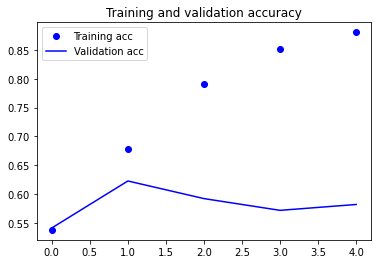

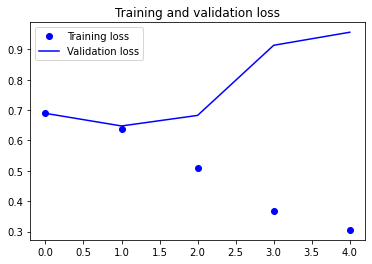

In [68]:
plot_graphs()